In [1]:
import pandas as pd
import xarray as xr
import datetime as dt
import json
import pytz
#first import the relevant python packages

import numpy as np
import os 
import urllib
import matplotlib.pyplot as plt

from pysolar.solar import *

# User inputs

In [2]:
datelist = ['20221230', '20221231', '20230101','20230102','20230103','20230104', '20230105', '20230106', '20230107']
local_download_dir = '../data/sosnoqc/'

# Define some helper functions

In [3]:
'''
radsys_grabber.py

Given a start and end date, this will load radys data into an xarray dataset
'''
def get_daily_radsys_data(start, end):
    # url to request from
    base_url = 'https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/'

    # format dates
    if not isinstance(start, dt.date): 
        start = dt.datetime.strptime(start,'%Y-%m-%d')
    if not isinstance(end, dt.date): 
        end = dt.datetime.strptime(end ,'%Y-%m-%d')

    # get time delta    
    delta = end - start
    
    dates = []
    for i in range(delta.days + 1):
        dates.append(start + dt.timedelta(days=i))

    url_list = []
    for date in dates:
        if date.timetuple().tm_yday < 10:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}00{date.timetuple().tm_yday}.dat')
        elif date.timetuple().tm_yday < 100:
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}0{date.timetuple().tm_yday}.dat')
        else: 
            url_list.append(base_url+f'ckp{str(date.year)[-2:]}{date.timetuple().tm_yday}.dat')
    datasets = []
    for fn in url_list:
        # read in data
        print(f'Grabbing {fn}...')
        ckp_df = pd.read_csv(fn, 
                             skiprows=2, 
                             header=None, 
                             delim_whitespace=True, 
                             parse_dates={'time':[0,2,3,4,5]}, 
                             infer_datetime_format=True)
        datasets.append(met_data_formatting(ckp_df))
        print('Done!')
    radsys_ds = xr.concat(datasets, dim='time')
    radsys_ds.attrs.update({'QC_flag':'0 for good data, 1 for bad data, 2 for questionable data',
                       'no_data': -9999.9,
                       'time':'UTC',
                       'reported_data':'Reported data are 1 minute averages of 1 second samples, reported times are the end of the 1-min. averaging period',
                       'datastreamname':'Radsys'})
    # add a coordinate with LocalTime for Plotting
    # time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
    # us_mtn = pytz.timezone('US/Mountain')
    # tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    # local_da=xr.DataArray.from_series(tz_corrected)
    # radsys_ds.coords.update({'local_time':tz_corrected})


    with open('../modules/lab5/radsys_attributes.txt', 'r') as j:
        attribute_dict = json.loads(j.read())
    for variable in radsys_ds.variables:
        if variable in attribute_dict.keys():
            radsys_ds[variable].attrs.update(attribute_dict[variable])
    return radsys_ds

def met_data_formatting(ckp_df):
    
    # Convert DateTime column to datetime
    ckp_df['time'] = pd.to_datetime(ckp_df['time'], format='%Y %m %d %H %M')
    # Add column numbers
    col_num = [1,2,3,4,5,6,7,8,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51]
    col_num = [num - 1 for num in col_num]
    col_names = ["yyyy","jday","month","day","hour","min","dt","SZA","dw_solar","uw_solar","Direct horizontal","Diffuse",
                "dw_ir","DwCaseTemp","DwDomeTemp","uw_ir","UwCaseTemp","UwDomeTemp","UVB","PAR","NetSolar","NetIR",
                "TotalNet","AirTemp","RH","WindSpd","WindDir","Baro","SPN1_total_Avg","SPN1_diffuse_Avg"]
    ckp_df = ckp_df.rename(columns = dict(zip(col_num, col_names))) 
    # Create QC column names
    qc_col_numbers = ckp_df.columns[5::2]
    new_qc_names = [f'{col_name}_qc' for col_name in ckp_df.columns[4::2]]
    ckp_df = ckp_df.rename(columns = dict(zip(qc_col_numbers,new_qc_names)))

    ckp_ds = ckp_df.set_index('time', drop=True).to_xarray()
    return ckp_ds

def download_sos_data_day(date, local_download_dir, cache=True):
    """Download a netcdf file from the ftp url provided by the Earth Observing 
    Laboratory at NCAR. Data comes in one NetCDF file per day, Reynolds-Averaged 
    with a 5-minute averaging period.

    Args:
        date (str, optional): String representing a date in format '%Y%m%d'. Defaults to '20221101'.
        local_download_dir (str, optional): Directory to which files will be downloaded. Defaults 
                    to 'sosnoqc'; this directory will be created if it  does not already exist.
        cache (bool, optional): If True, looks in `local_download_dir` for requested  file, if it 
                    exists, does not redownload file. If False, downloads file from the FTP server.

    Returns:
        _type_: Relative path to the downloaded file
    """
    base_url = 'ftp.eol.ucar.edu'
    path = 'pub/archive/isfs/projects/SOS/netcdf/noqc_geo'
    file = f'isfs_{date}.nc'
    os.makedirs(local_download_dir, exist_ok=True)
    full_file_path = os.path.join('ftp://', base_url, path, file)
    download_file_path = os.path.join(local_download_dir, file)
    if cache and os.path.isfile(download_file_path):
        print(f"Caching...skipping download for {date}")
    else:
        urllib.request.urlretrieve(
            full_file_path,
            download_file_path   
        )
    return download_file_path

# Download data

## SoS data

In [4]:
files = [download_sos_data_day(d, local_download_dir) for d in datelist]
sos_datasets = [xr.open_dataset(f) for f in files]
sos_ds = xr.concat(sos_datasets, dim='time')


Caching...skipping download for 20221230
Caching...skipping download for 20221231
Caching...skipping download for 20230101
Caching...skipping download for 20230102
Caching...skipping download for 20230103
Caching...skipping download for 20230104
Caching...skipping download for 20230105
Caching...skipping download for 20230106
Caching...skipping download for 20230107


### Do some calculations

In [5]:
SIGMA = 5.67e-8 # Stephan-Boltzmann Constant
sos_ds = sos_ds.assign(
    LWout = (sos_ds.Rpile_out_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA),          
    LWin = (sos_ds.Rpile_in_9m_d + (sos_ds.Tcase_out_9m_d+273.15)**4*SIGMA)
)

In [6]:
VARIABLES = ['Rsw_in_9m_d',
            'Rsw_out_9m_d',
            'LWout',
            'LWin']

sos_ds = sos_ds[VARIABLES]

### Create 30min resampled dataset

In [24]:
sos_ds_30min = sos_ds.resample(time='30Min').mean()

## SPLASH data

In [7]:
radsys_ds = get_daily_radsys_data(
    dt.datetime.strptime(datelist[0], '%Y%m%d').strftime('%Y-%m-%d'),
    dt.datetime.strptime(datelist[-1], '%Y%m%d').strftime('%Y-%m-%d')
)

Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22364.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp22365.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23001.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23002.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23003.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23004.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23005.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23006.dat...
Done!
Grabbing https://gml.noaa.gov/aftp/data/radiation/campaigns/Format/ckp/ckp23007.dat...
Done!


### Correct time zone

In [8]:
time_utc = radsys_ds['time'].to_index().tz_localize(pytz.UTC)
us_mtn = pytz.timezone('US/Mountain')
tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
local_da=xr.DataArray.from_series(tz_corrected)
radsys_ds.coords.update({'LocalTime':tz_corrected})

### Filter  bad radiation data

In [9]:
radsys_ds['dw_solar'] = radsys_ds.where(radsys_ds['dw_solar_qc'] == 0)['dw_solar']
radsys_ds['uw_solar'] = radsys_ds.where(radsys_ds['uw_solar_qc'] == 0)['uw_solar']
radsys_ds['dw_ir'] = radsys_ds.where(radsys_ds['dw_ir_qc'] == 0)['dw_ir']
radsys_ds['uw_ir'] = radsys_ds.where(radsys_ds['uw_ir_qc'] == 0)['uw_ir']

### Create a 30min resampled dataset

In [22]:
radsys_ds_30min = radsys_ds.resample(time='30min').mean()

## Precipitation data

In [12]:
precip_xr = xr.open_dataset('../modules/data/precipitation.nc')
precip_df = precip_xr.to_dataframe().reset_index()
precip_df['daily_precip'] = precip_df['acc_prec'].diff().fillna(0)
precip_df = precip_df[(precip_df.date >= dt.datetime.strptime(datelist[0], '%Y%m%d')) & (precip_df.date <= dt.datetime.strptime(datelist[-1], '%Y%m%d'))]


## Use Pysolar to get clear sky radiation time series

In [13]:
kettle_ponds_lat_lon = [-106.97298,38.94182]
dates = pd.date_range(
    dt.datetime.strptime(datelist[0], '%Y%m%d'),
    dt.datetime.strptime(datelist[-1], '%Y%m%d'), 
    freq='1H'
)
clear_sky_rad = []
for date in dates:
    date = (pytz.utc.localize(date)).to_pydatetime()
    altitude_deg = get_altitude(kettle_ponds_lat_lon[1], kettle_ponds_lat_lon[0], date)
    clear_sky_rad.append(radiation.get_radiation_direct(date, altitude_deg))
clearsky_df = pd.DataFrame({'date': dates, 'radiation': clear_sky_rad})

/home/elilouis/mambaforge/envs/arm/lib/python3.11/site-packages/pysolar/solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \


# Problem 1: Comparing solar radiation sensors

A common problem in mountain snow energy balance studies is that snow accumulates on the upward pointing radiometers. Find a time in our dataset when you think this occurred and explain your reasoning. Hint, you may want to look at the precipitation dataset in Lab 2 for timing. Which radiometer set-up (SOS or SPLASH) worked better during your timeperiod? Why do you think this is? Compare downwelling and reflected shortwave radiation with potential shortwave radiation for your day.

In [25]:
sos_ds
radsys_ds
precip_df
clear_sky_rad
print("hi")

hi


(19356.0, 19364.0)

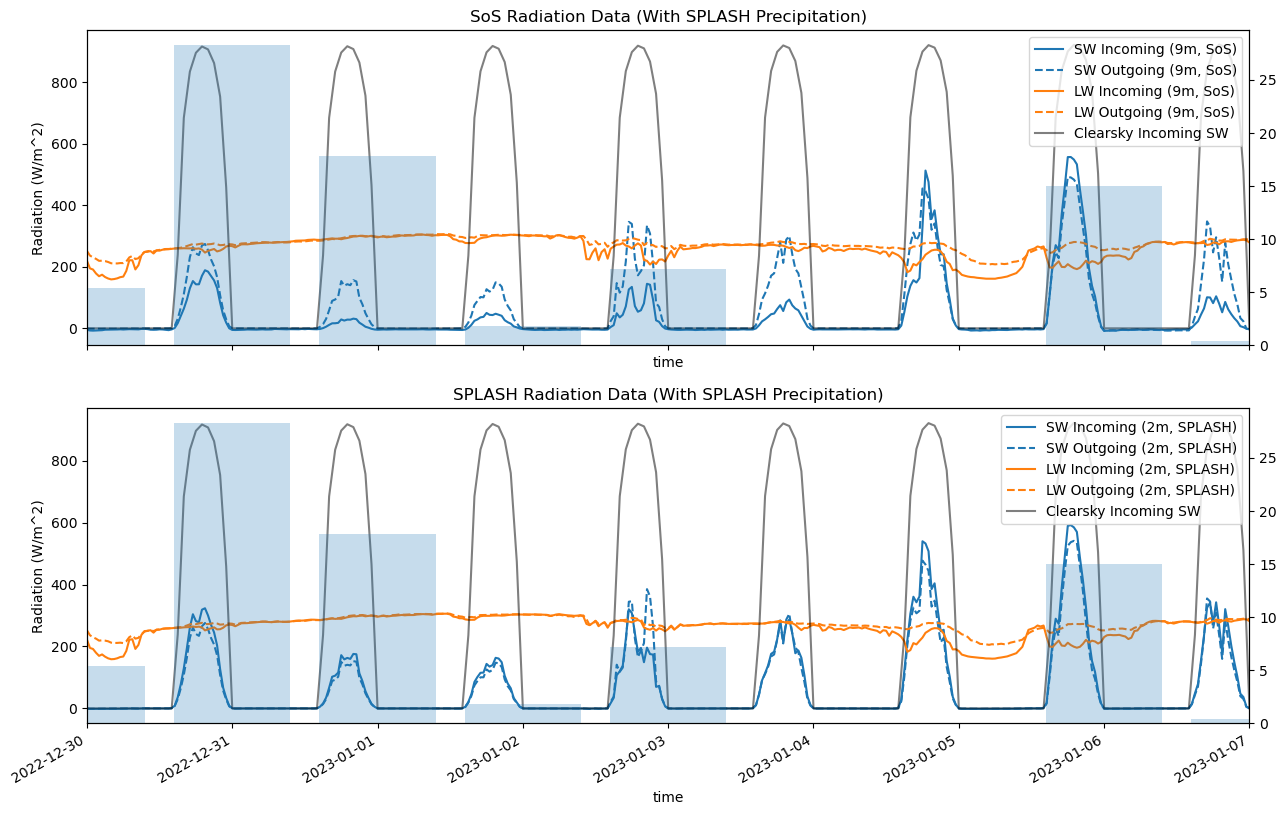

In [37]:
fix, [ax1, ax2] = plt.subplots(2, 1, figsize=(15,9), sharex=True)

sos_ds_30min['Rsw_in_9m_d'].plot(label='SW Incoming (9m, SoS)', ax=ax1, color='tab:blue')
sos_ds_30min['Rsw_out_9m_d'].plot(label='SW Outgoing (9m, SoS)', ax=ax1, color='tab:blue', linestyle='--')
sos_ds_30min['LWin'].plot(label='LW Incoming (9m, SoS)', ax=ax1, color='tab:orange')
sos_ds_30min['LWout'].plot(label='LW Outgoing (9m, SoS)', ax=ax1, color='tab:orange', linestyle='--')
ax1.plot(clearsky_df['date'], clearsky_df['radiation'], color='k', alpha=0.5, label='Clearsky Incoming SW ')
ax1_twin = ax1.twinx()
ax1_twin.bar(precip_df['date'], precip_df['daily_precip'], alpha=0.25)
ax1.legend(loc='upper right')
ax1.set_ylabel("Radiation (W/m^2)")


radsys_ds_30min['dw_solar'].plot(label='SW Incoming (2m, SPLASH)', ax=ax2, color='tab:blue')
radsys_ds_30min['uw_solar'].plot(label='SW Outgoing (2m, SPLASH)', ax=ax2, color='tab:blue', linestyle='--')
radsys_ds_30min['dw_ir'].plot(label='LW Incoming (2m, SPLASH)', ax=ax2, color='tab:orange')
radsys_ds_30min['uw_ir'].plot(label='LW Outgoing (2m, SPLASH)', ax=ax2, color='tab:orange', linestyle='--')
ax2.plot(clearsky_df['date'], clearsky_df['radiation'], color='k', alpha=0.5, label='Clearsky Incoming SW ')
ax2_twin = ax2.twinx()
ax2_twin.bar(precip_df['date'], precip_df['daily_precip'], alpha=0.25)

ax2.legend(loc='upper right')
ax2.set_ylabel("Radiation (W/m^2)")

ax1.set_title("SoS Radiation Data (With SPLASH Precipitation)")
ax2.set_title("SPLASH Radiation Data (With SPLASH Precipitation)")
plt.xlim(dt.datetime.strptime(datelist[0], '%Y%m%d'), dt.datetime.strptime(datelist[-1], '%Y%m%d'))

# Problem 2: Clouds

Identify a period of variable cloud cover in the dataset. Explain how you can use both shortwave and longwave measurements to identify variations in clouds. include periods from both day and nighttime hours. How are the shortwave and longwave datasets complimentary? Do they tell you the same or different information about the clouds?



(19359.0, 19360.0)

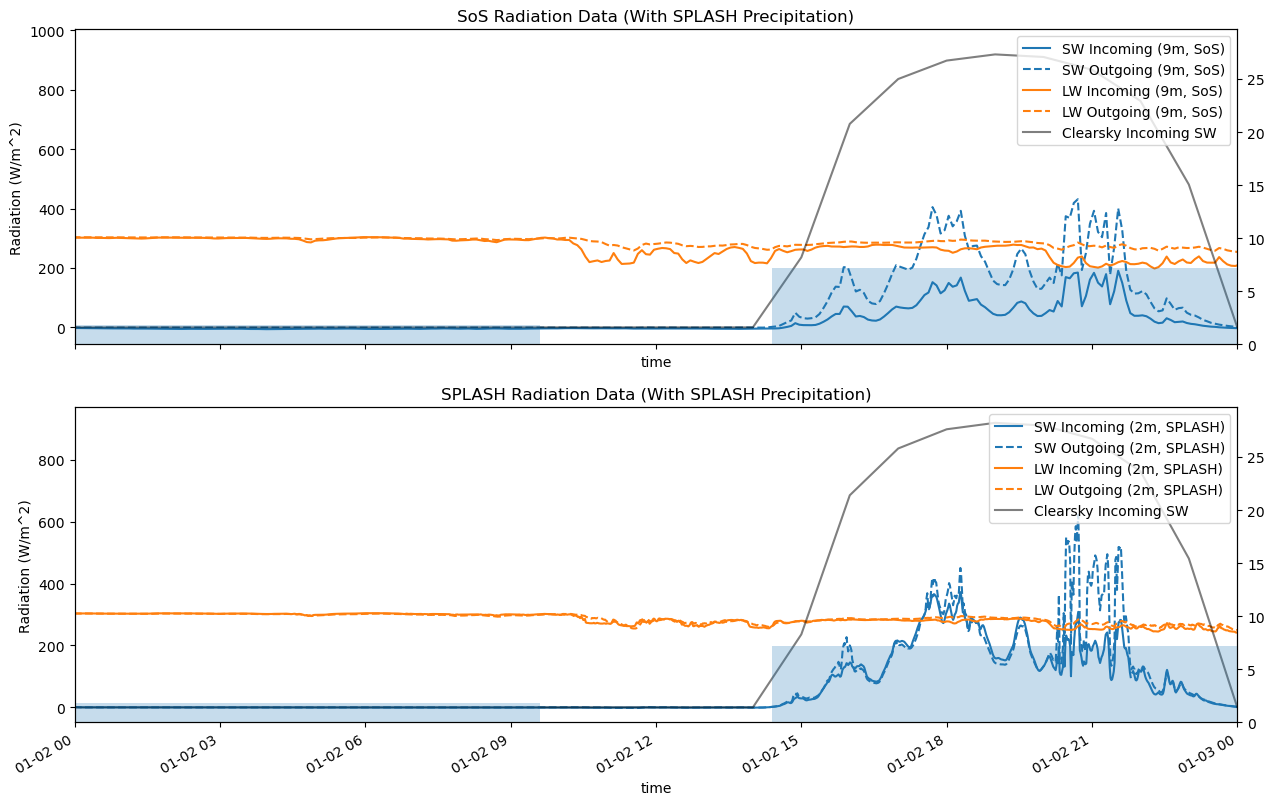

In [41]:
fix, [ax1, ax2] = plt.subplots(2, 1, figsize=(15,9), sharex=True)

sos_ds['Rsw_in_9m_d'].plot(label='SW Incoming (9m, SoS)', ax=ax1, color='tab:blue')
sos_ds['Rsw_out_9m_d'].plot(label='SW Outgoing (9m, SoS)', ax=ax1, color='tab:blue', linestyle='--')
sos_ds['LWin'].plot(label='LW Incoming (9m, SoS)', ax=ax1, color='tab:orange')
sos_ds['LWout'].plot(label='LW Outgoing (9m, SoS)', ax=ax1, color='tab:orange', linestyle='--')
ax1.plot(clearsky_df['date'], clearsky_df['radiation'], color='k', alpha=0.5, label='Clearsky Incoming SW ')
ax1_twin = ax1.twinx()
ax1_twin.bar(precip_df['date'], precip_df['daily_precip'], alpha=0.25)
ax1.legend(loc='upper right')
ax1.set_ylabel("Radiation (W/m^2)")


radsys_ds['dw_solar'].plot(label='SW Incoming (2m, SPLASH)', ax=ax2, color='tab:blue')
radsys_ds['uw_solar'].plot(label='SW Outgoing (2m, SPLASH)', ax=ax2, color='tab:blue', linestyle='--')
radsys_ds['dw_ir'].plot(label='LW Incoming (2m, SPLASH)', ax=ax2, color='tab:orange')
radsys_ds['uw_ir'].plot(label='LW Outgoing (2m, SPLASH)', ax=ax2, color='tab:orange', linestyle='--')
ax2.plot(clearsky_df['date'], clearsky_df['radiation'], color='k', alpha=0.5, label='Clearsky Incoming SW ')
ax2_twin = ax2.twinx()
ax2_twin.bar(precip_df['date'], precip_df['daily_precip'], alpha=0.25)

ax2.legend(loc='upper right')
ax2.set_ylabel("Radiation (W/m^2)")

ax1.set_title("SoS Radiation Data (With SPLASH Precipitation)")
ax2.set_title("SPLASH Radiation Data (With SPLASH Precipitation)")
plt.xlim(dt.datetime.strptime(datelist[3], '%Y%m%d'), dt.datetime.strptime(datelist[4], '%Y%m%d'))